In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

In [51]:
vocab_size = 16
X = torch.randint(0, vocab_size, (5, ))
X_onehot = F.one_hot(X, num_classes=vocab_size).float()
g = torch.Generator().manual_seed(99)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:

# X -> Vec -> Y
# we take the sequence X into a vector represetation (Encoder)
# And later we take that vector representation and tranform it in to a new sequence Y (Decoder)


# Encoder

#for i in T:
	#hx[t] = f(hx[t-1], x[t])
#C = hx[T-1]

#Decoder
# hy[t] = f(hy[t-1], y[t-1], C)


# Encoder

#for i in T:
	#hx[t] = f(hx[t-1], x[t])
#C = hx[T-1]

In [90]:
hidden_size = 32
# reset gate weights
Wr = torch.randn(vocab_size, hidden_size)
Ur = torch.randn(hidden_size, hidden_size)

# update gate weights
Wz = torch.randn(vocab_size, hidden_size)
Uz  = torch.randn(hidden_size, hidden_size)

# x-to-h Weights
Wxh = torch.randn(vocab_size, hidden_size)
Whh = torch.randn(hidden_size, hidden_size)

#
V = torch.randn(hidden_size, hidden_size)


In [91]:
h = torch.zeros((1, hidden_size))
t = 0

r = F.sigmoid((X_onehot[t] @ Wr) + (h @ Ur)) # the reset gate
z = F.sigmoid((X_onehot[t] @ Wr) + (h @ Ur)) # updated gate

# This gate decides if we keep h[t-1] to update h
# if r is rougly zeros, ignores the previous hidden state and only carries x[t]'s projection to h 
# to perform the update.
reset_gate = (X_onehot[t] @ Wxh) + (h * r) @ Whh

# the update gate, decides wheter we need to update h or not, however not binary yes or no.
# is a smoothed decision, interpolates what was kept from the reset gate in [0,1]
h1 = z * h + (1-z) * reset_gate


In [5]:
# Encoder
T, _ = X_onehot.shape

h = torch.zeros((1, hidden_size))

for t in range(T):
	r = F.sigmoid((X_onehot[t] @ Wr) + (h @ Ur)) # the reset gate
	z = F.sigmoid((X_onehot[t] @ Wz) + (h @ Uz)) # updated gate
	update = F.tanh((X_onehot[t] @ Wxh) + (r * h) @ Whh)
	h = z*h + (1-z)*update

C = F.tanh(h@V)

In [3]:
import kagglehub
import pandas as pd

In [4]:
path = kagglehub.dataset_download("lonnieqin/englishspanish-translation-dataset")

100%|██████████| 2.72M/2.72M [00:01<00:00, 2.17MB/s]

Extracting files...


In [5]:
import os
from pathlib import Path
file =  Path(path) / "data.csv"
df = pd.read_csv(file)

In [6]:
df.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [7]:
import re

class Tokenizer:
	def __init__(self, target: str):
		if target not in ["english", "spanish"]:
			raise ValueError("Target must be one of : ['english', 'spanish']")

		self.target = target

		# special tokens
		self.eos_token = "<EOS>" # end of sequence
		self.sos_token = "<SOS>" # start of sequence
		self.unk_token = "<UNK>" # unknown 
		self.pad_token = "<PAD>" # padding 

		self.special_tokens = [
			self.pad_token,
			self.eos_token,
			self.sos_token,
			self.unk_token,
		]

		#vocab
		self.vocab = self.build_vocab(target, special_tokens=self.special_tokens)
		self.vocab_size = len(self.vocab)

		# mappings
		self.token_to_idx = {token: idx for idx, token in enumerate(self.vocab)}
		self.idx_to_token = {idx: token for idx, token in enumerate(self.vocab)}

	def tokenize(self, s: str) -> list[str]:
		s = re.sub(r"([.!?])", r" \1", s)
		tokens = s.split()
		return tokens

	def build_vocab(self, target: str, special_tokens: list[str]):
		vocab = set()
		sentences = df[target]
		for s in sentences:
			tokens = self.tokenize(s)
			for token in tokens:
				vocab.add(token)
		return special_tokens + sorted(list(vocab))

	def encode(self, s: str) -> torch.Tensor:
		SOS = [self.token_to_idx[self.sos_token]]
		EOS = [self.token_to_idx[self.eos_token]]
		out = []
		for token in self.tokenize(s):
			idx = self.token_to_idx.get(token, self.token_to_idx[self.unk_token])
			out.append(idx)
		return torch.tensor(SOS + out + EOS)

	def decode(self, indices: list[int]) -> str:
		out = []
		UNK_IDX = self.token_to_idx[self.unk_token]
		EOS_IDX = self.token_to_idx[self.eos_token]
		SOS_IDX = self.token_to_idx[self.sos_token]
		for idx in indices:
			if idx == SOS_IDX:
				continue
			if idx == EOS_IDX:
				break
			out.append(self.unk_token if idx == UNK_IDX else self.idx_to_token[idx])
		return " ".join(out)

In [8]:
en_tokenizer = Tokenizer(target="english")
es_tokenizer = Tokenizer(target="spanish")

In [9]:
en_tokenizer.idx_to_token[0], en_tokenizer.token_to_idx["<PAD>"]

('<PAD>', 0)

In [10]:
tokens_en = en_tokenizer.encode("Hello how are you today my friend?")
tokens_es = es_tokenizer.encode("hola como estas hoy amigo? xdxd")

In [11]:
print(tokens_en, en_tokenizer.decode(tokens_en.tolist()))
print(tokens_es, es_tokenizer.decode(tokens_es.tolist()))

tensor([    2,  1741,  9602,  4231, 17364, 16057, 11459,  8643,   504,     1]) Hello how are you today my friend ?
tensor([    2, 18632, 10983, 16342, 18713,  7166,   536,     3,     1]) hola como estas hoy amigo ? <UNK>


In [12]:
# This maks represents:
# 1 -> active sequence (padding token not reached yet at current t)
# 0 -> inactive sequence (reached padding tokens)
# This mask will be used to prevent updates to hidden vector to inactive sequences, preventing the padding index to affect hidden state.
# I call an inactive sequence here at t, if at any given point s[t] = pad_idx.
# s = [4, 5, 6, 7, pad, pad, pad, pad] # up to t = 3 the sequence is active, for t >= 4, inactive.
class PaddingMask(nn.Module):
	def __init__(self, pad_idx):
		super().__init__()
		self.pad_idx = pad_idx

	def forward(self, lengths: torch.Tensor, t: int, h: torch.Tensor, prev_h: torch.Tensor):
		mask = (t < lengths).float().to(h.device)
		block = h * mask
		carry = (1 - mask) * prev_h
		return block + carry

def test_pad_masking(X, Y):
	X = X[:10, :]
	Y = Y[:10, :]

	X = X.to(device)
	Y = Y.to(device)

	B, T = X.shape

	pad_idx = es_tokenizer.token_to_idx[es_tokenizer.pad_token]
	pad_mask = PaddingMask(
		pad_idx=pad_idx
	)
	# important to preverse dimensions here for the mask to be applied to the correct hidden vector of the corresponding sequence.
	lengths = torch.sum((X != pad_idx).int(), dim=-1, keepdim=True) 
	prev_h = torch.ones(B, 8) * 0.5
	h = torch.ones(B, 8)
	masked_h = pad_mask(lengths, 8, h, prev_h)
	print(masked_h)


#test_pad_masking(X, Y)


In [52]:
class Encoder(nn.Module):
	def __init__(self, hidden_size, emb_dim, vocab_size, pad_idx):
		super().__init__()

		# used to avoid hidden state computation from pad_idx tokenes.
		self.pad_idx = pad_idx
		self.padding_mask = PaddingMask(pad_idx)

		self.hidden_size = hidden_size 
		self.vocab_size = vocab_size

		self.embeddings = nn.Embedding(vocab_size, emb_dim, device=device)

		self.Wr = nn.Linear(emb_dim, hidden_size)
		self.Ur  = nn.Linear(hidden_size, hidden_size)

		# update gate weights
		self.Wz = nn.Linear(emb_dim, hidden_size)
		self.Uz  = nn.Linear(hidden_size, hidden_size)

		# x-to-h Weights
		self.Wxh = nn.Linear(emb_dim, hidden_size)
		self.Whh = nn.Linear(hidden_size, hidden_size)

		self.V = nn.Linear(hidden_size, hidden_size)

	def forward(self, X: torch.Tensor):
		lengths = torch.sum((X != self.pad_idx).int(), dim=-1, keepdim=True)

		Xemb = self.embeddings(X)
		B, T, _ = Xemb.shape
		h = torch.zeros((B, self.hidden_size), device=device)
			
		for t in range(T):
			r = F.sigmoid((self.Wr(Xemb[:, t])) + self.Ur(h)) # the reset gate
			z = F.sigmoid(self.Wz(Xemb[:, t]) + self.Uz(h)) # updated gate
			update = F.tanh(self.Wxh(Xemb[:, t]) + self.Whh(r*h))
			prev_h = h.clone()
			h = z*h + (1-z)*update
			h = self.padding_mask(lengths, t, h, prev_h) # mask inactive sequences


		C = F.tanh(self.V(h))
		return C

In [53]:
def f():
	hidden_size = 5
	D = 16
	B = 4

	Whh  = torch.randn(hidden_size, hidden_size)
	Whx = torch.randn(D, hidden_size)

	h = torch.randn(1, 5)

	Xt = torch.randn(B, D)

	#next_h = xt@Whx + h @ Whh  [1,D] @ (D, h) -> h + (1, h) @ (h, h) -> h = h + h -> h
	next_h = Xt@Whx + h @ Whh  #[B,D] @ (D, h) -> (B, h) + (1, h) @ (h, h) -> h = h + h -> h

	print(next_h)

f()

tensor([[  3.7956,  -2.9026,  -1.7941,  -1.0793,   0.2862],
        [  1.2947,  -1.2020,   0.3307,   3.9937,   0.5437],
        [ 19.4545,  -2.6037,  -8.1631, -11.3877,   1.0924],
        [ -6.1610,   3.3924,  -8.2159,   3.4970,   0.9449]])


In [54]:
class Decoder(nn.Module):
	def __init__(self, hidden_size, emb_dim, vocab_size):
		super().__init__()

		self.hidden_size = hidden_size
		self.vocab_size = vocab_size

		self.embeddings = nn.Embedding(vocab_size, emb_dim, device=device)
		self.V = nn.Linear(hidden_size, hidden_size, bias=False)

		#update gate
		self.Cz = nn.Linear(hidden_size, hidden_size, bias=False)
		self.Uz = nn.Linear(hidden_size, hidden_size, bias=False)
		self.Wz = nn.Linear(emb_dim, hidden_size, bias=False)

		#reset gate
		self.Cr = nn.Linear(hidden_size, hidden_size, bias=False)
		self.Ur = nn.Linear(hidden_size, hidden_size, bias=False)
		self.Wr = nn.Linear(emb_dim, hidden_size, bias=False)

		#update params
		self.U = nn.Linear(hidden_size, hidden_size, bias=False)
		self.C = nn.Linear(hidden_size, hidden_size, bias=False)
		self.W = nn.Linear(emb_dim, hidden_size, bias=False)

		# output
		# Im using 2*vocab_size as the target size here since we are using maxout for output
		# keeping it close to what the paper does oringinally.
		# Might change it to something simpler.
		d = 64 # move this to config

		self.Oh = nn.Linear(hidden_size, 2 * d, bias=False)
		self.Oy = nn.Linear(emb_dim, 2 * d, bias=False)
		self.Oc = nn.Linear(hidden_size, 2 * d, bias=False)

		self.G = nn.Linear(d, vocab_size, bias=False)
		

	def forward(self, c: torch.Tensor, Y: torch.tensor):
		#h =  F.tanh(c @ self.V)
		h = F.tanh(self.V(c))

		Yemb = self.embeddings(Y)
		B, T, D = Yemb.shape

		#y_logits = []
		y_logits = torch.zeros(B, T-1, self.vocab_size, device=device)

		#[B, D]
		for t in range(1, T):
			#update gate
			#z =  F.sigmoid(Yemb[t-1]@self.Wz +  h@self.Uz + c@self.Cz)
			z = F.sigmoid(self.Wz(Yemb[:, t-1]) + self.Uz(h) + self.Cz(c))
			
			#r =  F.sigmoid(Yemb[t-1]@self.Wr +  h@self.Ur + c@self.Cr)
			#reset gate
			r = F.sigmoid(self.Wr(Yemb[:, t-1]) + self.Ur(h) + self.Cr(c))

			#candidate update to h
			#update = F.tanh((Yemb[t-1] @ self.W) + r*(h @ self.U + c@self.C))
			update = F.tanh((self.W(Yemb[:, t-1])) + r * (self.U(h) + self.C(c)))

			#update
			h = z*h + (1-z)*update

			# [1, 2*h] => s = [s1, s2, s3, s4, ..... ] #
			# [[s1, s2],
			# [s3, s4]

			# MAX OUT (Might be a good idea to turn this into a module)
			#s_ = h @ self.Oh + Yemb[t-1] @ self.Oy + c @ self.Oc
			s_ = self.Oh(h) + self.Oy(Yemb[:, t-1]) + self.Oc(c)
			s = s_.view(B, -1, 2).max(dim=-1).values

			logits = self.G(s)
			y_logits[:, t-1] = logits

		return y_logits

	def generate(self, c: torch.Tensor, max_output_tokens : int = 16):
		sos_idx = torch.tensor(es_tokenizer.token_to_idx[es_tokenizer.sos_token]).to(device)
		eos_idx = es_tokenizer.token_to_idx[es_tokenizer.eos_token]
		#print(f"Encoder c: mean={c.abs().mean()}, norm={c.norm()}")

		## NOTE: Preserve Batching
		## This is very subtle, and could cause wrong calculation down the stream
		## we need to add bactching here or otherwise we likely get broadcasting issues and wrong calculations
		y_prev = self.embeddings(sos_idx).unsqueeze(0) ## [1, emb_dim]

		target_tokens = []
		
		y_token_idx = -1

		h = F.tanh(self.V(c))
		while y_token_idx != eos_idx and len(target_tokens) < max_output_tokens:
			#update gate
			z = F.sigmoid(self.Wz(y_prev) + self.Uz(h) + self.Cz(c))
			#reset gate
			r = F.sigmoid(self.Wr(y_prev) + self.Ur(h) + self.Cr(c))
			#candidate update to h
			candidate = F.tanh(self.W(y_prev) + r * (self.U(h) + self.C(c)))
			#update
			h = z*h + (1-z)*candidate

			# output
			s_ = self.Oh(h) + self.Oy(y_prev) + self.Oc(c)
			s = s_.view(1, -1, 2).max(dim=-1).values
			y_logits = self.G(s)

			#sample
			probs = F.softmax(y_logits, dim=-1)
			y_token_idx = torch.argmax(probs, dim=-1).item()
			target_tokens.append(y_token_idx)

			y_prev = self.embeddings(torch.tensor(y_token_idx).to(device)).unsqueeze(0) # [1, emb_dim] (Check NOTE)

		return torch.tensor(target_tokens)



In [55]:
print(en_tokenizer.encode("Hello how are you today my friend?"))
print(es_tokenizer.encode("hola como estas hoy amigo?"))

tensor([    2,  1741,  9602,  4231, 17364, 16057, 11459,  8643,   504,     1])
tensor([    2, 18632, 10983, 16342, 18713,  7166,   536,     1])


In [66]:
from dataclasses import dataclass

@dataclass
class Config:
	hidden_size = 32
	emb_dim = 64 # 500 in paper
	encoder_vocab_size = len(en_tokenizer.vocab)
	decoder_vocab_size = len(es_tokenizer.vocab)
	batch_size = 32
	pad_idx = en_tokenizer.token_to_idx[en_tokenizer.pad_token]

In [57]:
class Model(nn.Module):
	def __init__(self, config: Config):
		super().__init__()
		self.encoder = Encoder(config.hidden_size, config.emb_dim, config.encoder_vocab_size, pad_idx=Config.pad_idx)
		self.decoder = Decoder(config.hidden_size, config.emb_dim, config.decoder_vocab_size)

	def forward(self, X: torch.Tensor, Y: torch.Tensor):
		c = self.encoder(X) 
		return self.decoder(c, Y)

	def generate(self, X: torch.Tensor, debug=False):
		c = self.encoder(X)
		return self.decoder.generate(c) if not debug else self.decoder.generate(torch.zeros_like(c))

In [58]:
class EnglishSpanishDataset(Dataset):
	def __init__(self, en_tokenizer: Tokenizer, es_tokenizer: Tokenizer, df: pd.DataFrame):
		super().__init__()
		self.df = df
		self.en_tokenizer = en_tokenizer
		self.es_tokenizer = es_tokenizer

		assert len(df[self.en_tokenizer.target]) == len(df[self.es_tokenizer.target])

	def __getitem__(self, index): 
		en = df[self.en_tokenizer.target]
		es = df[self.es_tokenizer.target]

		src = en[index]
		target = es[index]
		return en_tokenizer.encode(src), es_tokenizer.encode(target)

	def __len__(self):
		return len(df[self.en_tokenizer.target])


In [59]:
dataset = EnglishSpanishDataset(en_tokenizer, es_tokenizer, df)
train_dataset, test_dataset = random_split(dataset, [0.80, 0.20], generator=g)

In [60]:
class BatchProcess:
	def __init__(self, pad_idx_src, pad_idx_dst):
		self.pad_idx_src = pad_idx_src
		self.pad_idx_dst = pad_idx_dst

	def __call__(self, batch):
		# Adds padding to both target and source sententes.
		X, Y = [], []
		max_x, max_y = 0, 0

		for sample in batch:
			x, y = sample
			max_x = max(len(x), max_x)
			max_y = max(len(y), max_y)

		for sample in batch:
			x, y = sample

			padded_x = torch.cat([x, torch.tensor([self.pad_idx_src] * (max_x - len(x)), dtype=torch.long)])
			padded_y = torch.cat([y, torch.tensor([self.pad_idx_dst] * (max_y - len(y)), dtype=torch.long)])

			X.append(padded_x)
			Y.append(padded_y)

		return torch.vstack(X), torch.vstack(Y)


In [61]:
batch_process = BatchProcess(
	pad_idx_src=en_tokenizer.token_to_idx[en_tokenizer.pad_token], # both are the same since we use the same tokenizer, but better to pass both anyways
	pad_idx_dst=es_tokenizer.token_to_idx[es_tokenizer.pad_token]
)
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=batch_process)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=True, collate_fn=batch_process)

In [62]:
def g():
	pad_idx = en_tokenizer.token_to_idx[en_tokenizer.pad_token]
	X, Y = next(iter(train_loader))
	print(X.shape)
	lengths = torch.sum((X != pad_idx).int(), dim=-1)
	print(lengths)

g()

torch.Size([32, 18])
tensor([10,  7,  6, 10,  7, 11, 10,  9, 10,  7, 18, 15,  9,  9, 11, 12, 14,  9,
        12, 13, 10,  6,  6,  6,  6,  9, 10, 10,  7, 14,  9,  8])


In [65]:
model = Model(Config).to(device)
num_params = sum([p.numel() for p in model.parameters()])
size_mb = sum([p.numel() * p.element_size() for p in model.parameters()]) / (1024**2)
print(f"Parameters: {num_params:,} | Size: {size_mb:.2f} MB")

Parameters: 8,476,352 | Size: 32.33 MB


In [120]:
def generate(model: Model, src: str, debug:bool=False):
	X = en_tokenizer.encode(src).to(device).unsqueeze(0)
	target_token_indices = model.generate(X, debug=debug)
	translation = es_tokenizer.decode(target_token_indices.cpu().tolist())
	return translation

es_tokens = generate(model, src="Hello, How are you?", debug=False)
es_tokens

'verificación introdujiste tapar lógico Despiérteme dejaras Despiérteme dejaras renuncio europeos, obviamente entreteniendo gasta tanque ex-novia autocorrigió'

In [121]:
# FORWARD PASS TEST
pad_idx = en_tokenizer.token_to_idx[en_tokenizer.pad_token]
for X, Y in train_loader:

	print(f"SRC = {X[:1]}")
	print(f"TARGET = {Y[:1]}")
	print(f"Expected initial LOSS -> {-torch.log(torch.tensor(1/Config.decoder_vocab_size)):.4f}")
	X = X.to(device)
	Y = Y.to(device)
	with torch.no_grad():
		model.eval()
		y_logits = model.forward(X, Y)
		y_log_probs = F.log_softmax(y_logits, dim=-1)
		y_log_probs.shape # 
		B, T, Y_VOCAB = y_log_probs.shape
		#L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), Y.view(B * T)) # SKIP <SOS>

		# Batched version of nll_loss call, this function doesnt like batches so we need to adjust the shapes.
		L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), 
					   Y[:, 1:].contiguous().view(-1),
				 	   #Y[:, 1:].reshape(B * (Y.size(1) - 1)), 
				       ignore_index=pad_idx)

		#L = F.nll_loss(y_log_probs[:, ], Y[0, 1:]) # SKIP <SOS>
		print(f"Initial Loss : {L.item():.4f}" )
		model.train()
	break

SRC = tensor([[    2,  1820,  7300, 16460, 17048, 17368, 16315, 16050, 13978,   175,
             1,     0,     0,     0,     0,     0]])
TARGET = tensor([[    2,  3850, 15569, 20817, 25719, 25873, 12866,   256,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]])
Expected initial LOSS -> 10.3841
Initial Loss : 10.4673


In [122]:
# Accuracy on one batch on data.
def accuracy(pad_idx: int, Y: torch.Tensor, y_log_probs: torch.Tensor):
	# i dont want to include pad indices in the accuracy
	indices = Y[:, 1:] != pad_idx
	yreal = Y[:, 1:][indices]  # real indices
	ypredicted = torch.argmax(y_log_probs[:, :, :], dim=-1)[indices] # predicted indices
	return torch.mean((yreal == ypredicted).float(), dtype=torch.float)

In [120]:
#es_tokenizer.decode(torch.argmax(y_log_probs[12, :, :], dim=-1).cpu().tolist())
#y_log_probs.shape
#pad_idx = es_tokenizer.token_to_idx[es_tokenizer.pad_token]
#indices = Y[0, 1:] != pad_idx
#torch.mean(Y[0, 1:][indices] == torch.argmax(y_log_probs[0, :, :], dim=-1)[indices].float(), dtype=torch.float)

In [123]:
# Overfitting one example as sanity check: Loss should go down fast
def overfit_one_batch(X, Y, epochs=300, log_step=10):
	X = X.to(device)
	Y = Y.to(device)

	optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0)

	#src = en_tokenizer.decode(X[:1].tolist())
	#target = es_tokenizer.decode(Y[:1].tolist())
	#print(f"SRC = {src} \nTARGET = {target}")

	for i in range(epochs):
		optimizer.zero_grad()


		y_logits = model.forward(X, Y)
		y_log_probs = F.log_softmax(y_logits, dim=-1)
		B, T, Y_VOCAB = y_log_probs.shape
		#L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), Y.view(B * T)) # SKIP <SOS>

		# Batched version of nll_loss call, this function doesnt like batches so we need to adjust the shapes.
		L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), 
					   Y[:, 1:].contiguous().view(-1),
				 	   #Y[:, 1:].reshape(B * (Y.size(1) - 1)), 
				       ignore_index=pad_idx)


		if (i + 1) % log_step == 0:
			print(f"Loss: {L.item():.4f}")

		L.backward()

		#clip gradients
		torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

		optimizer.step()

In [124]:
X, Y = next(iter(train_loader))

In [125]:
overfit_one_batch(X, Y, epochs=500, log_step=20)

Loss: 7.9240
Loss: 3.5192
Loss: 2.4244
Loss: 1.5390
Loss: 0.9864
Loss: 0.7609
Loss: 0.6511
Loss: 0.5679
Loss: 0.5032
Loss: 0.4524
Loss: 0.4001
Loss: 0.3478
Loss: 0.2960
Loss: 0.2339
Loss: 0.1688
Loss: 0.1133
Loss: 0.0738
Loss: 0.0478
Loss: 0.0318
Loss: 0.0226
Loss: 0.0172
Loss: 0.0137
Loss: 0.0114
Loss: 0.0096
Loss: 0.0083


In [126]:
print(en_tokenizer.decode(X[0].cpu().tolist()))
print(es_tokenizer.decode(Y[0].cpu().tolist()))

The car is waxed and shining .
El auto está encerado y reluciente .


In [127]:
src = en_tokenizer.decode(X[0].cpu().tolist())
target = generate(model, src, debug=False)
target

'El auto está encerado y reluciente .'

In [128]:
def ff(X, Y):
	with torch.no_grad():
		X = X.to(device)[:1]
		Y = Y.to(device)[:1]
		print("src -> " + en_tokenizer.decode(X[0].cpu().tolist()))
		print("target -> " + es_tokenizer.decode(Y[0].cpu().tolist()))
		logits = model.forward(X, Y)
		log_probs = F.log_softmax(logits, dim=-1)
		B, T, D = log_probs.shape
		loss = F.nll_loss(log_probs.view(B*T, D), Y[:, 1:].contiguous().view(-1), ignore_index=pad_idx)
		print(loss.item())
ff(X, Y)

src -> The car is waxed and shining .
target -> El auto está encerado y reluciente .
0.00715081999078393


In [129]:
def teacher_forcing_vs_auto_regressive_test(X, Y):
	with torch.no_grad():
		model.eval()
		x = X[1:2].to(device)
		y = Y[1:2].to(device)
		print(x.shape, y.shape)

		print("Source:", en_tokenizer.decode(x[0].cpu().tolist()))
		print("Target:", es_tokenizer.decode(y[0].cpu().tolist()))

		#encoded src
		c = model.encoder(x)

		# teacher forcing forward
		logits = model.decoder(c, y)
		print("\nTEACHER FORCING SAMPLE:\n")
		s1 = es_tokenizer.decode(torch.argmax(logits[0], dim=-1).cpu().tolist())
		print(f"{s1}\n")

		# inference autoregressive foward
		gen_tokens = model.decoder.generate(c)
		print("\nAUTOREGRESSIVE SAMPLE:\n")
		print(es_tokenizer.decode(gen_tokens.cpu().tolist()))


		# Check if first token is correct
		first_logits = logits[0, 0]  # logits for first token
		first_pred = torch.argmax(first_logits).item()
		first_target = y[0, 1].item()  # y[0] is <SOS>, y[1] is first real token
		print(f"\nFirst token - predicted: {first_pred} ({es_tokenizer.idx_to_token.get(first_pred, '???')}), target: {first_target} ({es_tokenizer.idx_to_token.get(first_target, '???')})")
		model.train()

teacher_forcing_vs_auto_regressive_test(X, Y)

torch.Size([1, 14]) torch.Size([1, 14])
Source: If I had time to do that, I would .
Target: Si tuviera tiempo de hacerlo, lo haría .

TEACHER FORCING SAMPLE:

Si tuviera tiempo de hacerlo, lo haría .


AUTOREGRESSIVE SAMPLE:

Si tuviera tiempo de hacerlo, lo haría .

First token - predicted: 4919 (Si), target: 4919 (Si)


In [130]:
def sample_from_loader(x):
	sen = en_tokenizer.decode(x.tolist()[0])
	print(f"SRC_X:{x}")
	print(f"SRC_STRING:{sen}")

	# pasando muestra directo the train loader (TIENE PADDING)
	c = model.encoder(x.to(device))
	gen = model.decoder.generate(c)
	gen_str = es_tokenizer.decode(gen.cpu().tolist())
	print(f"GEN:{gen_str}")

def sample_from_string(s):
	x = en_tokenizer.encode(s).unsqueeze(0) # batching

	print(f"SRC_X:{x}")
	print(f"SRC_STRING:{s}")

	c = model.encoder(x.to(device))
	gen = model.decoder.generate(c)
	gen_str = es_tokenizer.decode(gen.cpu().tolist())
	print(f"GEN -> {gen_str}")


def bug():
	x = X[1:2] #batched sample
	x_string = en_tokenizer.decode(x.tolist()[0])
	print("#" * 10 + "FROM LOADER" + "#" * 10)
	sample_from_loader(x)
	print("#" * 20)
	print("#" * 10 + "FROM TOKENIZING" + "#" * 10)
	sample_from_string(x_string) # THIS IS THE SAME SENTENCE CONTAINED IN x

bug()
	

##########FROM LOADER##########
SRC_X:tensor([[    2,  1840,  1820,  9149, 16022, 16050,  7252, 15861,  1820, 17283,
           175,     1,     0,     0]])
SRC_STRING:If I had time to do that, I would .
GEN:Si tuviera tiempo de hacerlo, lo haría .
####################
##########FROM TOKENIZING##########
SRC_X:tensor([[    2,  1840,  1820,  9149, 16022, 16050,  7252, 15861,  1820, 17283,
           175,     1]])
SRC_STRING:If I had time to do that, I would .
GEN -> Si tuviera tiempo de hacerlo, lo haría .


In [ ]:
def generate(model: Model, src: str, debug:bool=False):
	X = en_tokenizer.encode(src).to(device).unsqueeze(0)
	print(X.shape)
	target_token_indices = model.generate(X, debug=debug)
	translation = es_tokenizer.decode(target_token_indices.cpu().tolist())
	return translation

In [ ]:
def eval(model: Model, test_loader: DataLoader):
	test_loss = 0.0
	test_acc = 0.0
	model.eval()
	with torch.no_grad():
		test_loss = 0

		for Xt, Yt in test_loader:
			Xt = Xt.to(device)
			Yt = Yt.to(device)

			# forward pass on test batch
			y_logits_t = model.forward(Xt, Yt)
			y_log_probs_t = F.log_softmax(y_logits_t, dim=-1)
			B, T, Y_VOCAB = y_log_probs_t.shape
			Lt = F.nll_loss(y_log_probs_t.view(B*T, Y_VOCAB), 
						Yt[:, 1:].contiguous().view(-1),
						ignore_index=pad_idx)

			test_loss += Lt.item()
			test_acc += accuracy(pad_idx=es_tokenizer.token_to_idx[es_tokenizer.pad_token], 
								 Y=Yt, 
								 y_log_probs=y_log_probs_t)

	model.train()

	return test_loss / len(test_loader), test_acc / len(test_loader)
	
def train(model: Model, epochs: int, lr: float):
	model.train()
	optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
	
	log_step = 250

	train_losses = []
	train_accs = []

	test_losses = []
	test_accs = []

	for _ in range(1):
		loss = 0.0
		train_acc = 0.0

		for batch_idx, (X, Y) in enumerate(train_loader):
			X = X.to(device)
			Y = Y.to(device)

			optimizer.zero_grad()

			y_logits = model.forward(X, Y)
			y_log_probs = F.log_softmax(y_logits, dim=-1)
			B, T, Y_VOCAB = y_log_probs.shape
			#L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), Y.view(B * T)) # SKIP <SOS>

			# Batched version of nll_loss call, this function doesnt like batches so we need to adjust the shapes.
			L = F.nll_loss(y_log_probs.view(B*T, Y_VOCAB), 
						Y[:, 1:].contiguous().view(-1),
						#Y[:, 1:].reshape(B * (Y.size(1) - 1)), 
						ignore_index=pad_idx)


			train_acc += accuracy(pad_idx=es_tokenizer.token_to_idx[es_tokenizer.pad_token], 
								 Y=Y, 
								 y_log_probs=y_log_probs)

			loss += L.item()

			#backprop
			L.backward()

			#clip gradients
			torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

			#update params
			optimizer.step()
			
			#record loss
			if (batch_idx + 1) % log_step == 0:
				train_losses.append(loss / log_step)
				train_accs.append(train_acc / log_step)

				loss = 0
				train_acc = 0 

				# run loss and acc on test set
				test_loss, test_acc = eval(model, test_loader)

				test_losses.append(test_loss)
				test_accs.append(test_acc)

	train_accs = torch.stack(train_accs)
	test_accs = torch.stack(test_accs)
	
	return train_losses, train_accs, test_losses, test_accs


In [146]:
train_losses, train_accs, test_losses, test_accs = train(
	model,
	epochs=1,
	lr=0.001
)

In [ ]:
import matplotlib.pyplot as plt

def plot_training(train_losses, train_accs, test_losses, test_accs):
    steps = list(range(1, len(train_losses) + 1))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)

    # loss
    ax = axes[0]
    ax.plot(steps, train_losses, marker="o", linewidth=2, label="Train")
    ax.plot(steps, test_losses, marker="o", linewidth=2, label="Test")
    ax.set_title("Loss")
    ax.set_xlabel("Checkpoint (each = log_step batches)")
    ax.set_ylabel("NLL")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    # acc
    ax = axes[1]
    ax.plot(steps, train_accs, marker="o", linewidth=2, label="Train")
    ax.plot(steps, test_accs, marker="o", linewidth=2, label="Test")
    ax.set_title("Token Accuracy")
    ax.set_xlabel("Checkpoint (each = log_step batches)")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)  # accuracy is in [0,1]
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    fig.tight_layout()
    plt.show()

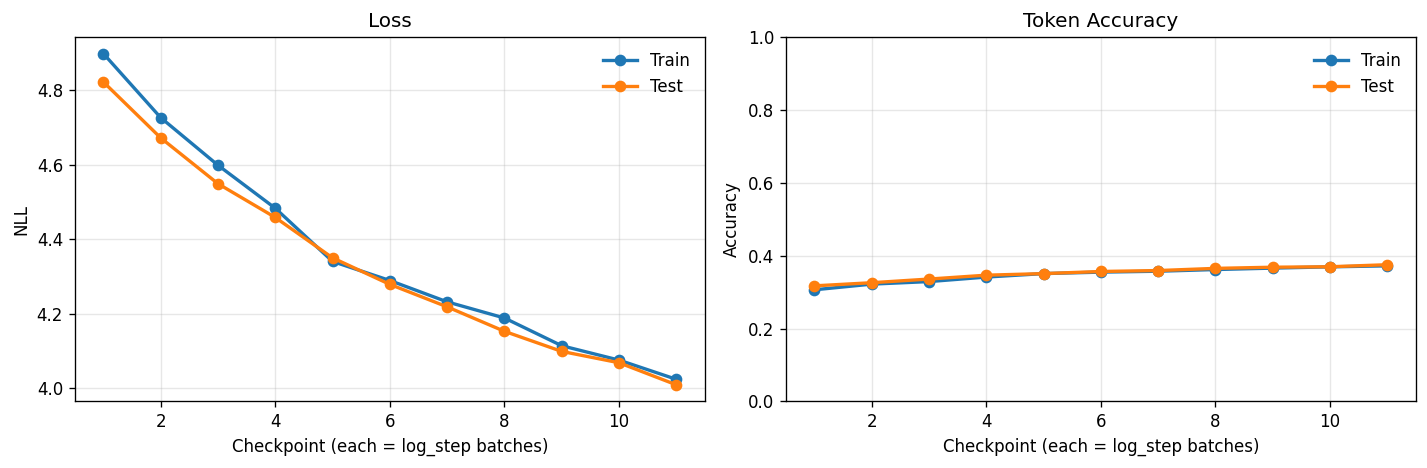

In [152]:
plot_training(train_losses, train_accs.cpu(), test_losses, test_accs.cpu())